In [41]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm

import matplotlib as mpl
font = {        'size'   : 15}
mpl.rc('font', **font)

In [2]:
# Getting the top 20 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]

In [3]:
invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
invitations_iwiw.head()

,RegYear,CityId,InvitorCityId,w
0,2002,379,379,3809
1,2002,379,380,6
2,2002,379,381,7
3,2002,379,382,8
4,2002,379,383,12


In [4]:
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
mask3 = invitations_iwiw["InvitorCityId"]!=invitations_iwiw["CityId"]

In [5]:
# Edgelist with only the top 19
reduced_df = invitations_iwiw[mask1&mask2]
reduced_df.head()
# print(len(reduced_df['InvitorCityId'].unique()))

,RegYear,CityId,InvitorCityId,w
0,2002,379,379,3809
1,2002,379,380,6
2,2002,379,381,7
3,2002,379,382,8
4,2002,379,383,12


In [25]:
Years = list(reduced_df['RegYear'].unique())
# for year in Years:
#     print(len(reduced_df[reduced_df['RegYear']==year]['CityId'].unique()))
Graph_list = [nx.to_numpy_array(nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                     source='InvitorCityId',target='CityId',edge_attr='w',
                                                          create_using=nx.DiGraph),weight='w',dtype=int)
             for year in Years]

# asymmetric, weighted tensor of size T x N x N
W = np.array(Graph_list)

# asymmetric, normalised tensor
W_norm = np.zeros_like(W,dtype='float64')
for t in range(W.shape[0]):
    W_norm[t,:,:] = W[t,:,:]
    np.fill_diagonal(W_norm[t,:,:],0) # removing all self-loops
    W_norm[t,:,:] /= W_norm[t,:,:].sum()

In [26]:
# symmetrised, weighted social connection tensor S
S = (W + np.transpose(W,axes=[0,2,1]))/2
# # correcting the self loops since double counted
# for i in range(S.shape[2]):
#     S[:,i,i] = S[:,i,i]/2
    
# under a null model of random graph
S_null = np.zeros_like(S)
for t in range(S.shape[0]):
    for i in range(S.shape[1]):
        for j in range(S.shape[2]):
            S_null[t,i,j] = S[t,i,:].sum()*S[t,j,:].sum()/S[t,:,:].sum()
            
# symmetrised, normalised social connection tensor S_norm
S_norm = np.zeros_like(S,dtype='float64')
for t in range(S.shape[0]):
    S_norm[t,:,:] = S[t,:,:]
    np.fill_diagonal(S_norm[t,:,:],0) # removing all self-loops
    S_norm[t,:,:] /= S_norm[t,:,:].sum()
# S_norm = S/S_null # fails due to zeros in S_null

Insert road network / distance matrix things. Assume will output a distance tensor $D$ of size $T \times N \times N$

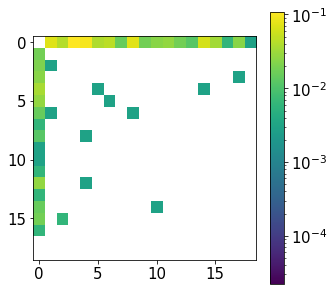

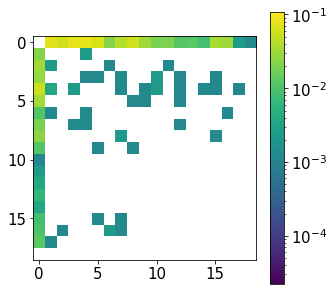

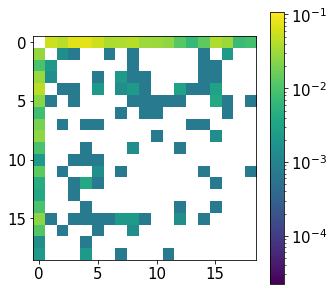

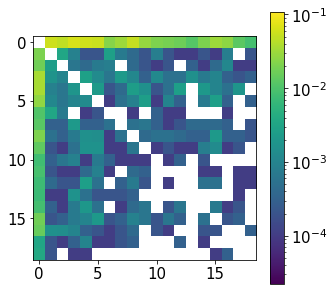

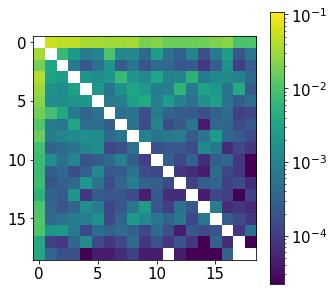

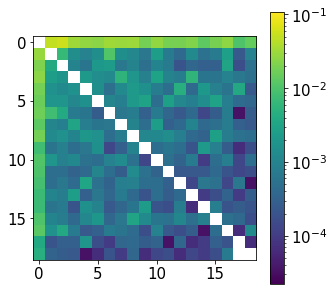

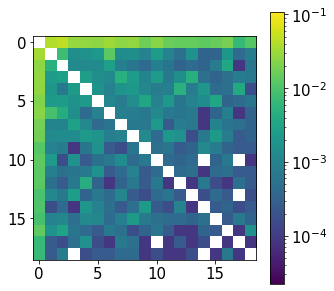

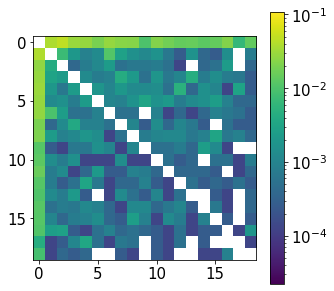

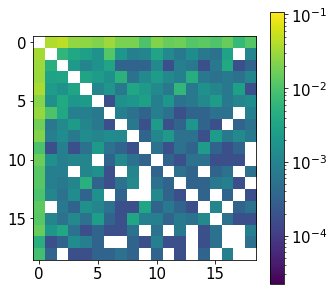

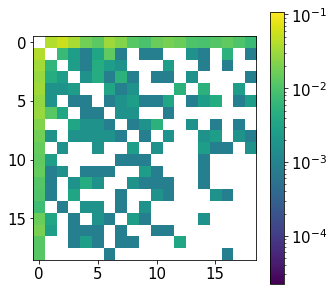

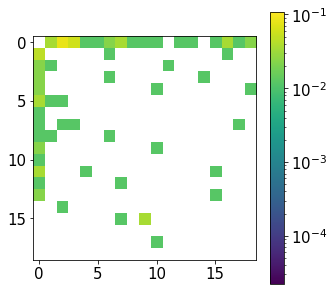

In [32]:
# Visualising S_norm for each year
for t in range(S.shape[0]):
    plt.figure(figsize=(5,5))
    im=plt.imshow(W_norm[t,:,:],
               norm=LogNorm(vmin=W_norm[W_norm>0].min(),vmax=W_norm.max()))
    plt.colorbar(im)

Text(0, 0.5, 'Normed Social Connection')

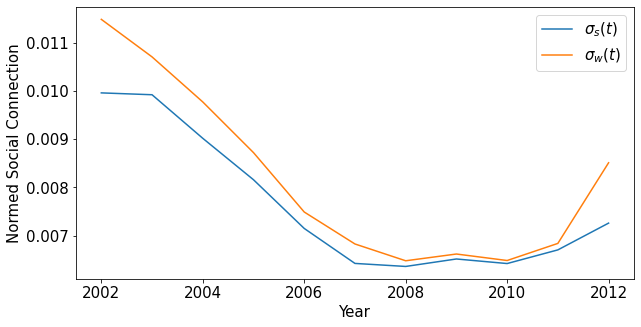

In [30]:
fig=plt.figure(figsize=(10,5))
# the mean is meaningless since we always normalise against the sum
# plt.plot(Years,[S_norm[t,:,:].mean() for t in range(S.shape[0])],label='mean')

plt.plot(Years,[S_norm[t,:,:].std() for t in range(S.shape[0])],label=r'$\sigma_s (t)$')
plt.plot(Years,[W_norm[t,:,:].std() for t in range(S.shape[0])],label=r'$\sigma_w (t)$')
plt.legend()
plt.xlabel("Year")
plt.ylabel("Normed Social Connection")

# Proper Analysis
Given the social connection tensor $S$ (or $W$) and distance tensor $D$. Note tensor here just means stack the relevant matrices at different timestamps on top of one another, e.g. $S$-tensor = $[S(t=0),S(t=1),...,S(t=T)]$

In [59]:
def lag_corr(A,B,t,tau):
    # A and B must be tensors with time on axis 0, the rest of the dimensions must be the same
    if t >= A.shape[0] or t+tau>=B.shape[0]:
        return 0
    else:
        return np.corrcoef(A[t,:,:].flatten(),B[t+tau,:,:].flatten())[0,1]
    
# Wrappers while we don't yet have D
def lag_corr_matrix(A,B):
    rho = np.zeros([A.shape[0],B.shape[0]])
    for t in range(A.shape[0]):
        for tau in range(B.shape[0]):
            rho[t,tau] = lag_corr(A,B,t,tau)
    return rho

def maximal_lag_corr(A,B):
    return np.max(lag_corr_matrix(A,B),axis=1)

def char_timescales(A,B):
    return np.argmax(lag_corr_matrix(A,B),axis=1)

In [58]:
rho = lag_corr_matrix(S,np.random.rand(11,19,19))
print(np.max(rho,axis=1))

[0.07134135 0.07155985 0.0714705  0.07129438 0.06302143 0.05586771
 0.05162194 0.         0.         0.         0.        ]
